# Predicting uncertainty with (deep) neural networks

The idea is that a network that outputs a real-valued prediction can be (simply) modified to provide an estimate of the error on this prediction. Roughly speaking we do:

* Add an additional real-valued output to the network. The network now predicts two values: the output, $y$, and its variance, $\sigma^2$

* Estimate the target value for the variance, $\sigma^2$, from the difference between the target value of the output, $y$, and its predicted value, $\hat{y}$, with $\sigma^2 = (y-\hat{y})^2$

* An easy way to do this at training time is with a customised loss function

### Imports 

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline

### Generate some random data

In [56]:
# Generate some linearly related data
n_samples = 10000
x = np.random.random(n_samples)
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps

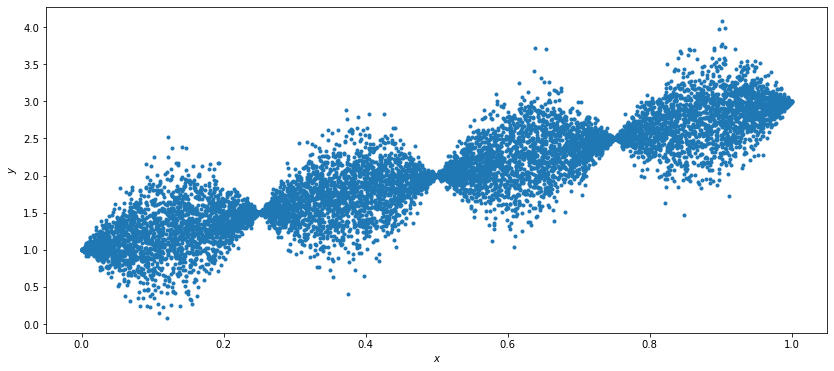

In [57]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [58]:
# Add in column of dummy zeros to represent the variance 
var = np.zeros(10000)
y = np.stack([y, var], axis=1)

In [59]:
y

array([[3.09483682, 0.        ],
       [2.84433217, 0.        ],
       [2.73358828, 0.        ],
       ...,
       [2.07374422, 0.        ],
       [0.90454001, 0.        ],
       [1.7332156 , 0.        ]])

In [60]:
# Reshape x for PyTorch
x = x.reshape(10000, 1)

In [61]:
# Split into training and validation sets
n_validation = 500
x_val, x = x[:n_validation], x[n_validation:]
y_val, y = y[:n_validation], y[n_validation:]

In [62]:
y

array([[3.04232488, 0.        ],
       [1.01227896, 0.        ],
       [2.61952621, 0.        ],
       ...,
       [2.07374422, 0.        ],
       [0.90454001, 0.        ],
       [1.7332156 , 0.        ]])

In [63]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [65]:
for i in y:
    print(i)

tensor([3.0423, 0.0000])
tensor([1.0123, 0.0000])
tensor([2.6195, 0.0000])
tensor([2.3845, 0.0000])
tensor([1.5019, 0.0000])
tensor([1.6064, 0.0000])
tensor([1.1519, 0.0000])
tensor([2.4955, 0.0000])
tensor([2.4574, 0.0000])
tensor([1.0561, 0.0000])
tensor([2.6356, 0.0000])
tensor([0.6747, 0.0000])
tensor([1.5666, 0.0000])
tensor([1.0596, 0.0000])
tensor([1.8188, 0.0000])
tensor([2.0060, 0.0000])
tensor([1.3872, 0.0000])
tensor([2.1789, 0.0000])
tensor([1.0169, 0.0000])
tensor([1.6826, 0.0000])
tensor([2.9478, 0.0000])
tensor([0.8091, 0.0000])
tensor([0.9049, 0.0000])
tensor([1.2699, 0.0000])
tensor([3.1124, 0.0000])
tensor([1.3957, 0.0000])
tensor([2.4118, 0.0000])
tensor([1.4485, 0.0000])
tensor([1.3379, 0.0000])
tensor([1.3439, 0.0000])
tensor([2.4993, 0.0000])
tensor([1.7973, 0.0000])
tensor([1.4780, 0.0000])
tensor([2.2350, 0.0000])
tensor([2.7998, 0.0000])
tensor([1.9555, 0.0000])
tensor([2.0226, 0.0000])
tensor([1.6442, 0.0000])
tensor([2.4138, 0.0000])
tensor([2.8425, 0.0000])


In [50]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([9500, 1]), torch.Size([9500, 2]))

### Create a simple network 

In [51]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           ).cpu()

In [52]:
# Adam optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [53]:
def custom_loss(input, target):
    
    # Estimate target value for variance (sigma^2) with (y_pred - y)**2
    #
    #    actual y        is target[:,0]
    # predicted y        is input[:,0]
    #    actual variance is target[:,1] - estimated here
    # predicted variance is input[:,0]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data)**2, 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [54]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    print(y)
    # if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data[0]:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

tensor([[1.5431, 2.1471],
        [2.6223, 7.5582],
        [1.3763, 2.2519],
        ...,
        [1.7887, 2.8839],
        [2.4812, 7.0685],
        [1.0447, 0.9332]])
tensor([[1.5431, 1.4396],
        [2.6223, 5.9585],
        [1.3763, 1.4233],
        ...,
        [1.7887, 2.0582],
        [2.4812, 5.4581],
        [1.0447, 0.4910]])
tensor([[1.5431, 0.8756],
        [2.6223, 4.5546],
        [1.3763, 0.7864],
        ...,
        [1.7887, 1.3745],
        [2.4812, 4.0614],
        [1.0447, 0.1907]])
tensor([[1.5431, 0.4553],
        [2.6223, 3.3503],
        [1.3763, 0.3406],
        ...,
        [1.7887, 0.8341],
        [2.4812, 2.8815],
        [1.0447, 0.0309]])
tensor([[1.5431, 0.1759],
        [2.6223, 2.3475],
        [1.3763, 0.0819],
        ...,
        [1.7887, 0.4356],
        [2.4812, 1.9195],
        [1.0447, 0.0063]])
tensor([[1.5431e+00, 3.0033e-02],
        [2.6223e+00, 1.5448e+00],
        [1.3763e+00, 6.0604e-06],
        ...,
        [1.7887e+00, 1.7313e-01],
 

KeyboardInterrupt: 

### Get predictions for validation set 

In [58]:
# Get predicted y and its predicted variance for validation set
x_val_pytorch = Variable(torch.from_numpy(x_val).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
variance_pred = pred[:,1].cpu().data

### Plot results

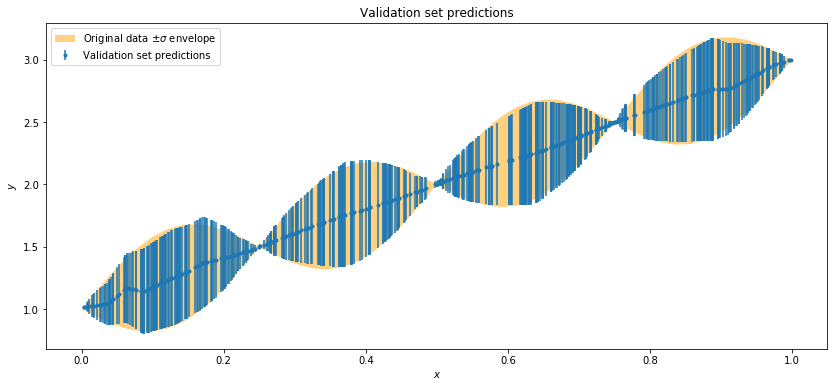

In [59]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_val, y_pred, yerr=variance_pred.sqrt() , fmt='.'); 

# One standard-deviation envelope
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.title('Validation set predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Validation set predictions'], loc='upper left', );